# Email Research Assistant


## Imports

In [1]:
import requests
import json
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel
from typing import List, Dict, Any
from langchain_core.prompts import ChatPromptTemplate
import os
import pathlib
from bs4 import BeautifulSoup
import re
from bs4 import BeautifulSoup
import re
from langchain_openai import ChatOpenAI
from pydantic import Field
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import HumanMessage, AIMessage
from __future__ import print_function
import sib_api_v3_sdk
from sib_api_v3_sdk.rest import ApiException
from IPython.display import Markdown, display

In [2]:
with open(".env", "r") as f:
    for line in f:
        key, value = line.strip().split("=")
        os.environ[key] = value


## Searching Google & Filtering Results

In [3]:
search_terms = ["Agentic AI", "OpenAI LinkedIn", "Agentic AI Enterprise"]

In [4]:
class ResultRelevance(BaseModel):
    explanation: str
    id: str

class RelevanceCheckOutput(BaseModel):
    relevant_results: List[ResultRelevance]

def search_serper(search_query):
    url = "https://google.serper.dev/search"
    
    payload = json.dumps({
        "q": search_query,
        "gl": "gb", 
        "num": 30,
        "tbs": "qdr:d"
    })

    headers = {
        'X-API-KEY': '0130e7da8283ec8a8d9721c6c38a97d557867923',
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    results = json.loads(response.text)
    results_list = results['organic']

    all_results = []
    for id, result in enumerate(results_list, 1):
        result_dict = {
            'title': result['title'],
            'link': result['link'],
            'snippet': result['snippet'],
            'search_term': search_query,
            'id': id
        }
        all_results.append(result_dict)
    return all_results

def load_prompt(prompt_name):
    with open(f"prompts/{prompt_name}.md", "r") as file:
        return file.read()


def check_search_relevance(search_results: Dict[str, Any]) -> RelevanceCheckOutput:
    """
    Analyze search results and determine the most relevant ones.
    
    Args:
        search_results: Dictionary containing search results to analyze
        
    Returns:
        RelevanceCheckOutput containing the most relevant results and explanation
    """
    prompt = load_prompt("relevance_check")
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", prompt)
    ])

    llm = ChatOpenAI(model="gpt-4o").with_structured_output(RelevanceCheckOutput)
    llm_chain = prompt_template | llm
    
    return llm_chain.invoke({'input_search_results': search_results})



relevant_results = []
for search_term in search_terms:
    python_results = search_serper(search_term)
    results = check_search_relevance(python_results)
    
    # Get the relevant result IDs from the LLM output
    relevant_ids = [r.id for r in results.relevant_results]
    
    # Filter original results to only include those with matching IDs
    filtered_results = [r for r in python_results if str(r['id']) in relevant_ids]
    
    relevant_results.extend(filtered_results)
  


In [5]:
relevant_results

[{'title': 'From Tutors to Transformers: How AI, AGI, and Agentic AI Are ...',
  'link': 'https://medium.com/@pramodaiml/from-tutors-to-transformers-how-ai-agi-and-agentic-ai-are-reshaping-education-687e73fd80b1',
  'snippet': "Agentic AI helps grade papers and track struggling students. Teachers save time, but there's a catch. When feedback is AI-generated, students sometimes question ...",
  'search_term': 'Agentic AI',
  'id': 2},
 {'title': "MIT Technology Review's Post - LinkedIn",
  'link': 'https://www.linkedin.com/posts/mit-technology-review_dont-let-hype-about-ai-agents-get-ahead-activity-7350028315681779713-WNIY',
  'snippet': 'Opinion: The vision of agentic AI is exciting: Intelligent software agents that act like digital coworkers, booking your flights, rescheduling meetings ...',
  'search_term': 'Agentic AI',
  'id': 5},
 {'title': 'The Agentic Race: Smart Lessons From Companies Leading the Way',
  'link': 'https://www.europeanbusinessreview.com/the-agentic-race-smart-les

## Scrape & Convert to Markdown

In [6]:
def convert_html_to_markdown(html_content):
    # Create BeautifulSoup object
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Convert common HTML elements to markdown
    
    # Headers
    for h in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
        level = int(h.name[1])
        h.replace_with('#' * level + ' ' + h.get_text() + '\n\n')
    
    # Links
    for a in soup.find_all('a'):
        href = a.get('href', '')
        text = a.get_text()
        if href and text:
            a.replace_with(f'[{text}]({href})')
    
    # Bold
    for b in soup.find_all(['b', 'strong']):
        b.replace_with(f'**{b.get_text()}**')
    
    # Italic
    for i in soup.find_all(['i', 'em']):
        i.replace_with(f'*{i.get_text()}*')
    
    # Lists
    for ul in soup.find_all('ul'):
        for li in ul.find_all('li'):
            li.replace_with(f'- {li.get_text()}\n')
    
    for ol in soup.find_all('ol'):
        for i, li in enumerate(ol.find_all('li'), 1):
            li.replace_with(f'{i}. {li.get_text()}\n')
    
    # Get text and clean up
    text = soup.get_text()
    
    # Remove excess whitespace/newlines
    text = re.sub(r'\n\s*\n', '\n\n', text)
    text = text.strip()
    
    return text

def scrape_and_save_markdown(relevant_results):
    """
    Scrapes HTML content from URLs in relevant_results and saves as markdown files.
    
    Args:
        relevant_results: List of dictionaries containing search results with URLs
        
    Returns:
        List of dictionaries containing markdown content and metadata
    """
    # Create scraped_html directory if it doesn't exist
    pathlib.Path("scraped_markdown").mkdir(exist_ok=True)

    markdown_contents = []
    for result in relevant_results:
        if 'link' in result:
            payload = {
                "api_key": "zZwEqATYReQC4ogVNYnaLUYdm47ITPMNiFbRtvw1o7IpQbTubwZUvnkCycrWx2wCWt9wuA4aUIizsSvtQH", 
                "url": result['link'],
                "render_js": "true"
            }

            response = requests.get("https://scraping.narf.ai/api/v1/", params=payload)
            if response.status_code == 200:
                # Create filename from ID or URL if ID not available
                filename = f"{result.get('id', hash(result['link']))}.md"
                filepath = os.path.join("scraped_markdown", filename)
                
                # Convert HTML to markdown
                markdown_content = convert_html_to_markdown(response.content.decode())
                
                # Save markdown content to file
                with open(filepath, 'w', encoding='utf-8') as f:
                    f.write(markdown_content)
                
                markdown_contents.append({
                    'url': result['link'],
                    'filepath': filepath,
                    'markdown': markdown_content,
                    'title': result.get('title', ''),
                    'id': result.get('id', '')
                })
            else:
                print(f"Failed to fetch {result['link']}: Status code {response.status_code}")

    print(f"Successfully downloaded and saved {len(markdown_contents)} pages as markdown to scraped_markdown/")
    return markdown_contents

markdown_contents = scrape_and_save_markdown(relevant_results)

Successfully downloaded and saved 15 pages as markdown to scraped_markdown/


In [7]:
markdown_contents

[{'url': 'https://medium.com/@pramodaiml/from-tutors-to-transformers-how-ai-agi-and-agentic-ai-are-reshaping-education-687e73fd80b1',
  'filepath': 'scraped_markdown/2.md',
  'markdown': 'From Tutors to Transformers: How AI, AGI, and Agentic AI Are Reshaping Education | by @pramodchandrayan | Jul, 2025 | Medium[Sitemap](/sitemap/sitemap.xml)[Open in app](https://rsci.app.link/?%24canonical_url=https%3A%2F%2Fmedium.com%2Fp%2F687e73fd80b1&%7Efeature=LoOpenInAppButton&%7Echannel=ShowPostUnderUser&%7Estage=mobileNavBar&source=post_page---top_nav_layout_nav-----------------------------------------)Sign up[Sign in](https://medium.com/m/signin?operation=login&redirect=https%3A%2F%2Fpramodaiml.medium.com%2Ffrom-tutors-to-transformers-how-ai-agi-and-agentic-ai-are-reshaping-education-687e73fd80b1&source=post_page---top_nav_layout_nav-----------------------global_nav------------------)[Medium Logo](https://medium.com/?source=post_page---top_nav_layout_nav-----------------------------------------

## Generate Summaries of Markdown

In [8]:
def generate_summaries(markdown_contents):
    """
    Generates summaries for markdown content using GPT-4.
    
    Args:
        markdown_contents: List of dictionaries containing markdown content and metadata
        
    Returns:
        List of dictionaries containing summaries and URLs
    """
    # Create markdown_summaries directory if it doesn't exist
    pathlib.Path("markdown_summaries").mkdir(exist_ok=True)

    # Load the summary prompt
    summary_prompt = load_prompt("summarise_markdown_page")

    # Create prompt template
    summary_template = ChatPromptTemplate.from_messages([
        ("system", summary_prompt)
    ])

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o")
    summary_chain = summary_template | llm

    # Generate and save summaries
    summaries = []
    for content in markdown_contents:
        try:
            # Generate summary, limiting to first 2000 words
            summary = summary_chain.invoke({
                'markdown_input': ' '.join(content['markdown'].split()[:2000])
            })
            
            # Create filename for summary
            summary_filename = f"summary_{content['id']}.md"
            summary_filepath = os.path.join("markdown_summaries", summary_filename)
            
            # Save summary to file
            with open(summary_filepath, 'w', encoding='utf-8') as f:
                f.write(summary.content)
            
            # Add to summaries list
            summaries.append({
                'markdown_summary': summary.content,
                'url': content['url']
            })
                
        except Exception as e:
            print(f"Failed to summarize {content['filepath']}: {str(e)}")

    print(f"Successfully generated summaries for {len(markdown_contents)} pages in markdown_summaries/")
    return summaries


summaries = generate_summaries(markdown_contents)

Successfully generated summaries for 15 pages in markdown_summaries/


In [9]:
summaries

[{'markdown_summary': '# Summary of the Article "From Tutors to Transformers: How AI, AGI, and Agentic AI Are Reshaping Education" by Pramod Chandrayan\n\nIn this Medium article, Pramod Chandrayan discusses the transformative impact of advanced artificial intelligence (AI), artificial general intelligence (AGI), and agentic AI on education. The article emphasizes that we are at a critical juncture where educational paradigms are shifting due to technological advances, not just through traditional reforms like curriculum overhauls.\n\n## Key Concepts\n\n1. **Artificial Intelligence (AI):** This refers to systems like personal assistants and recommendation engines (e.g., Netflix, Duolingo) that require user input to function.\n\n2. **Artificial General Intelligence (AGI):** Unlike current AI technologies, AGI, which is still largely theoretical, would represent a level of machine intelligence that could perform any intellectual task that a human can.\n\n3. **Agentic AI:** This is a conce

## LangGraph Email Summary & Review

### Graph State

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    summaries: List[dict]
    approved: bool
    created_summaries: Annotated[List[dict], Field(description="The summaries that have been created by the summariser")]

graph_builder = StateGraph(State)

### Summariser Node

In [11]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o")

In [12]:
# Load templates and prompts
with open("email_template.md", "r") as f:
    email_template = f.read()

class SummariserOutput(BaseModel):
    email_summary: str = Field(description="The summary email of the content")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

summariser_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("summariser")),
    ("placeholder", "{messages}"),
])

llm_summariser = summariser_prompt | llm.with_structured_output(SummariserOutput)

def summariser(state: State):
    summariser_output = llm_summariser.invoke({"messages": state["messages"], "list_of_summaries": state["summaries"], "input_template": email_template})
    new_messages = [AIMessage(content=summariser_output.email_summary), AIMessage(content=summariser_output.message)]
    return {"messages": new_messages, "created_summaries": [summariser_output.email_summary]}

### Reviewer Node

In [13]:
class ReviewerOutput(BaseModel):
    approved: bool = Field(description="Whether the summary is approved or not")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

reviewer_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("reviewer")),
    ("placeholder", "{messages}"),
])


llm_reviewer = reviewer_prompt | llm.with_structured_output(ReviewerOutput)


def reviewer(state: State):
    # Convert AIMessages to HumanMessages and vice versa
    converted_messages = []
    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            converted_messages.append(HumanMessage(content=msg.content))
        elif isinstance(msg, HumanMessage):
            converted_messages.append(AIMessage(content=msg.content))
        else:
            converted_messages.append(msg)
    state["messages"] = converted_messages
    reviewer_output = llm_reviewer.invoke({"messages": state["messages"]})
    new_messages = [HumanMessage(content=reviewer_output.message)]
    return {"messages": new_messages, "approved": reviewer_output.approved}


### Build the Graph

In [14]:
def conditional_edge(state: State) -> Literal["summariser", END]:
    if state["approved"]:
        return END
    else:
        return "summariser"


# Create and configure the graph
graph_builder.add_node("summariser", summariser)
graph_builder.add_node("reviewer", reviewer)
graph_builder.add_edge(START, "summariser")
graph_builder.add_edge("summariser", "reviewer")
graph_builder.add_conditional_edges('reviewer', conditional_edge)

# Compile and run the graph
graph = graph_builder.compile()

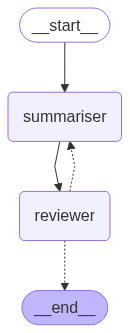

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

### Execute the Graph!

In [16]:
output = graph.invoke({"summaries": summaries})

In [17]:
final_summary = output["created_summaries"][-1]

display(Markdown(final_summary))


<h1>Big Company Updates 🌟</h1>

<p>Hello CTO, dive into today's fascinating AI world! From transforming education to revolutionizing business operations and cybersecurity adventures, let's explore exciting innovations in our tech-savvy universe. 🚀</p>

<h2>Key Highlights</h2>
<ul>
<li>📚 <strong>AI Revolutionizes Education:</strong> Advanced AI is transforming how students learn, offering a more personal and interactive experience. <a href="https://medium.com/@pramodaiml/from-tutors-to-transformers-how-ai-agi-and-agentic-ai-are-reshaping-education-687e73fd80b1">Explore further</a></li>
<li>🤖 <strong>Agentic AI Elevates Business:</strong> Companies like Siemens Energy and Unilever implement AI for innovative operational strategies. <a href="https://www.europeanbusinessreview.com/the-agentic-race-smart-lessons-from-companies-leading-the-way/">Explore further</a></li>
<li>🔒 <strong>Cybersecurity and AI Integration:</strong> AI's role in managing multi-cloud complexities poses new challenges and solutions. <a href="https://www.networkcomputing.com/network-security/navigating-the-future-of-cybersecurity-multi-cloud-challenges-ai-integration-and-agentic-ai">Explore further</a></li>
<li>🚀 <strong>OpenAI’s Latest Browser Endeavor:</strong> Launching a new browser featuring ChatGPT integration to compete with Chrome. <a href="https://www.komando.com/news/security/openai-wants-your-tabs/?srsltid=AfmBOorqogRTW_jUtd3po3omCgG9yCaAPwFWS-jYKTYexwtilUWkQHR4">Explore further</a></li>
</ul>

<h2>Deeper Dive</h2>

<h3>1. AI Transforms Education 📘</h3>
<p>Education is entering a new era where AI makes learning adaptive and personalized, enhancing student experiences. Emphasizing collaborative environments, this shift addresses ethical considerations. <a href="https://medium.com/@pramodaiml/from-tutors-to-transformers-how-ai-agi-and-agentic-ai-are-reshaping-education-687e73fd80b1">Explore further</a></p><p><strong>Why it matters:</strong> Tailoring education standards to integrate technology ensures equal access and efficacy in learning outcomes, empowering a smarter generation.</p>

<h3>2. Agentic AI Empowers Business 🚜</h3>
<p>Leading companies innovate by leveraging Agentic AI to streamline processes and tackle complexities. This strategic trend enables businesses to stay competitive in an evolving market. <a href="https://www.europeanbusinessreview.com/the-agentic-race-smart-lessons-from-companies-leading-the-way/">Explore further</a></p><p><strong>Why it matters:</strong> Revolutionizing operational modules with agentic AI paves the way for cost efficiency and enhanced decision-making in dynamic business landscapes.</p>

<h1>Industry Observations 🌍</h1>

<h2>Major Trends in the Industry</h2>
<ul>
<li>🏢 <strong>Enterprise AI Adoption on the Rise:</strong> Businesses are embracing agentic AI significantly to improve operational efficiency and productivity. <a href="https://x.com/bittingthembits/status/1944131116014649613">Explore further</a></li>
<li>💼 <strong>AI Reshaping Financial Practices:</strong> HPE leads by integrating AI in finance for improved decision-making and analytics. <a href="https://www.facebook.com/CrystalBallMarkets/posts/how-hewlett-packard-enterprises-cfo-uses-agentic-ai-to-shape-finance-and-her-dai/1133272152159229/">Explore further</a></li>
</ul>

<h2>Insights and Advancements</h2>

<h3>3. Expanding AI in Enterprises 💡</h3>
<p>Enterprises, inspired by frameworks like Bittensor, adopt small, agile teams to push AI innovation—creating flexible, robust ecosystems. <a href="https://x.com/bittingthembits/status/1944131116014649613">Explore further</a></p><p><strong>Why it matters:</strong> Flexible team dynamics drive rapid development, positioning enterprises at the technological forefront with customized solutions.</p>

<h3>4. AUG-AI Enhancements in Finance 📈</h3>
<p>HPE's strategic use of AI in finance transforms data analysis, emphasizing real-time insights and strategic planning enhancements. <a href="https://www.facebook.com/CrystalBallMarkets/posts/how-hewlett-packard-enterprises-cfo-uses-agentic-ai-to-shape-finance-and-her-dai/1133272152159229">Explore further</a></p><p><strong>Why it matters:</strong> Integrating AI-driven insights accelerates decision-making processes, enhances accuracy, and fosters growth in financial operations.</p>

## Send the Email

In [18]:
def send_email(email_content: str):
    """Send email using Sendinblue API"""
    configuration = sib_api_v3_sdk.Configuration()
    configuration.api_key['api-key'] = os.getenv("SENDINBLUE_API_KEY")
    
    api_instance = sib_api_v3_sdk.TransactionalEmailsApi(sib_api_v3_sdk.ApiClient(configuration))
    
    email_params = {
        "subject": "Daily AI Research Summary",
        "sender": {"name": "Will White", "email": "dhirajsanjayshah@gmail.com"},
        "html_content": email_content,
        "to": [{"email": "dhirajsanjayshah@gmail.com", "name": "Will White"}],
        "params": {"subject": "Daily AI Research Summary"}
    }
    
    send_smtp_email = sib_api_v3_sdk.SendSmtpEmail(**email_params)
    
    try:
        api_response = api_instance.send_transac_email(send_smtp_email)
        print(api_response)
    except ApiException as e:
        print(f"Exception when calling SMTPApi->send_transac_email: {e}\n")



send_email(final_summary)


Exception when calling SMTPApi->send_transac_email: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 13 Jul 2025 18:18:05 GMT', 'Content-Type': 'application/json', 'Content-Length': '72', 'Connection': 'keep-alive', 'access-control-allow-credentials': 'true', 'sib-request-id': '452feba5-20dc-9275-88ed-c156408604aa', 'access-control-allow-origin': '*', 'access-control-allow-headers': '*', 'access-control-allow-methods': 'PUT, POST, GET, DELETE, PATCH, OPTIONS', 'x-envoy-upstream-service-time': '1', 'cf-cache-status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '95eac7e958bcfba9-AMS'})
HTTP response body: {"message":"authentication not found in headers","code":"unauthorized"}



